In [12]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers.experimental.preprocessing import IntegerLookup
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt

import random

# Set the randomizer seed so results are the same each time.
np.random.seed(0)
random.seed(0)

In [3]:
#Load data into ratings_df. 
ratings_df = pd.read_csv("data/raw_data/ratings_small.csv", low_memory=False)
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [4]:
unique_movie_ids = np.unique(ratings_df['movieId'])
unique_user_ids = np.unique(ratings_df['userId'])
num_movies = len(unique_movie_ids)
num_users = len(unique_user_ids)
user2user_encoded = {x: i for i, x in enumerate(unique_user_ids)}
userencoded2user = {i: x for i, x in enumerate(unique_user_ids)}
movie2movie_encoded = {x: i for i, x in enumerate(unique_movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(unique_movie_ids)}
ratings_df["user"] = ratings_df["userId"].map(user2user_encoded)
ratings_df["movie"] = ratings_df["movieId"].map(movie2movie_encoded)

In [5]:
ratings_df["chron_ranking_by_user"] = ratings_df.groupby(["userId"])["timestamp"] \
                                             .rank(method='first', ascending=False)

train_ratings_df = ratings_df[ratings_df["chron_ranking_by_user"] > 2]
dev_ratings_df = ratings_df[ratings_df["chron_ranking_by_user"] == 2]
test_ratings_df = ratings_df[ratings_df["chron_ranking_by_user"] == 1]

In [6]:
train_ratings_df

,userId,movieId,rating,timestamp,user,movie,chron_ranking_by_user
0,1,31,2.5,1260759144,0,30,13.0
1,1,1029,3.0,1260759179,0,833,10.0
2,1,1061,3.0,1260759182,0,859,9.0
3,1,1129,2.0,1260759185,0,906,8.0
5,1,1263,2.0,1260759151,0,1017,11.0
...,...,...,...,...,...,...,...
99998,671,6212,2.5,1065149436,670,4507,13.0
99999,671,6268,2.5,1065579370,670,4545,8.0
100000,671,6269,4.0,1065149201,670,4546,19.0
100001,671,6365,4.0,1070940363,670,4597,4.0


In [73]:
embedding_size = 15
d1_size = 128

#Movie input network
input_movies = layers.Input(shape=[1])
#encoded_movies = IntegerLookup(vocabulary=unique_movie_ids)
embed_movies = layers.Embedding(num_movies + 1, embedding_size)(input_movies)
movies_out = layers.Flatten()(embed_movies)

#user input network
input_users = layers.Input(shape=[1])
#encoded_users = IntegerLookup(vocabulary=unique_user_ids)
embed_users = layers.Embedding(num_users + 1,embedding_size)(input_users)
users_out = keras.layers.Flatten()(embed_users)

conc_layer = keras.layers.Concatenate()([movies_out, users_out])
x = keras.layers.Dense(d1_size, activation='relu')(conc_layer)
x_out = x = keras.layers.Dense(1, activation='relu')(x)
model = keras.Model(inputs=[input_movies, input_users], outputs=x_out)

In [74]:
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mean_squared_error')
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 1, 15)        136005      input_7[0][0]                    
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 1, 15)        10080       input_8[0][0]                    
____________________________________________________________________________________________

In [75]:
hist = model.fit(
    x=[train_ratings_df.movie, train_ratings_df.user],
    y=train_ratings_df.rating, 
    batch_size=64, 
    epochs=5, 
    verbose=1,
    validation_data=([dev_ratings_df.movie, dev_ratings_df.user], dev_ratings_df.rating)
)

Epoch 1/5
1542/1542 [==============================] - 2s 1ms/step - loss: 1.3543 - val_loss: 0.9147
Epoch 2/5
1542/1542 [==============================] - 2s 1ms/step - loss: 0.7498 - val_loss: 0.9020
Epoch 3/5
1542/1542 [==============================] - 2s 1ms/step - loss: 0.7092 - val_loss: 0.8794
Epoch 4/5
1542/1542 [==============================] - 2s 1ms/step - loss: 0.6858 - val_loss: 0.8568
Epoch 5/5
1542/1542 [==============================] - 2s 1ms/step - loss: 0.6667 - val_loss: 0.8587


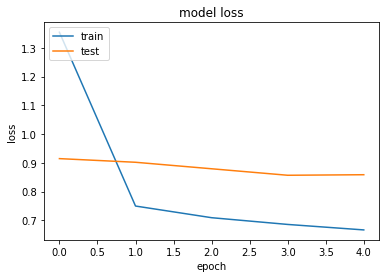

In [76]:
plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [10]:
def create_evalutaion_pools(train_df, test_df, pool_size=100):
    
    '''
    Create pools of movies to evaluate the collaborative filtering models.
    Each pool will contain pool_size movies per user. Each pool includes the 
    movies in the test_df and randomly selects the rest of the movies from 
    those not watched by the user.
    
    Parameters
    ----------
    train_df : A dataframe of the training ratings data
    test_df : A dataframe of the test ratings data
    pool_size : The size of each movie pool
    
    Returns
    -------
    evaluation_pools_dict : A dictionary from user to the pool of movies on 
                            which to evaluate the recommender system
    
    '''
    
    # Find the list of unique users and movies in the training data
    users = set(train_df['userId'].unique())
    movies = set(train_df['movieId'].unique())
    
    # Instantiate the output dictionary
    evaluation_pools_dict = {}
    
    # Loop through each user
    for user in users:
        
        # Find set of movies rated by the user in the training and test data
        train_movies = set(train_df[train_df['userId']==user]['movieId'])
        test_movies = set(test_df[test_df['userId']==user]['movieId'])
        
        # Find the set of movies not rated by the user
        movies_not_rated = movies - train_movies - test_movies
        
        # Randomly sample movies from the movies not rated by the user
        n_movies_to_choose = pool_size - len(test_movies)
        sample_movies_not_rated = set(random.sample(movies_not_rated, n_movies_to_choose))
        
        # Combine the test movies with the random sample of movies
        evaluation_pool = list(test_movies | sample_movies_not_rated)
        
        # Add each evaluation_pool to the output dictionary 
        evaluation_pools_dict[user] = evaluation_pool
    
    return evaluation_pools_dict

In [79]:
def sort_evaluation_pools(model, evaluation_pools, user2user_encoded, movie2movie_encoded):
    '''
    Take evaluation pool for each user and sort it based on ratings predicted by a 
    trained model in descending order of predicted ratings
    
    Parameters
    ----------
    model : A trained keras model
    evaluation_pools : A dictionary from user to the pool of movies on 
                       which to evaluate the recommender system 
    
    Returns
    -------
    sorted_evaluation_pools : A dictionary from user to the pool of movies where each 
                              movie is sorted in descending order of predicted movie 
                              rating
    '''
    
    # Instantiate output dictionary
    sorted_evaluation_pools = {}
    
    # Loop through each key-value pair in the input dictionary
    for user, movie_pool in evaluation_pools.items():
        
        # Convert to encoded is space
        user_encoded = np.array([user2user_encoded[user] for i in range(len(movie_pool))]) 
        movies_encoded =  np.array([movie2movie_encoded[movie] for movie in movie_pool])
        
        # Predict ratings based on model
        pred = model.predict([movies_encoded, user_encoded])
        pred = pred.reshape(-1)
        
        # Sort the pool in descending order of predicted ratings
        movie_pool_array = np.array(movie_pool)
        sorted_pool_array = movie_pool_array[pred.argsort()[::-1]]
        
        # Add key-value pair of user and sorted evalualtion pool to the output dictionary
        sorted_evaluation_pools[user] = sorted_pool_array.tolist()

    return sorted_evaluation_pools

In [15]:
def calc_hit_rate_pools(sorted_evaluation_pools, test_df, top_n=10):
    '''
    Calculate hit rate given a dictionary of sorted evaluation pools and the corrsponding 
    test data frame. A hit is defined as finding a test movie in the top_n of sorted 
    evalutation pool of a user
    Parameters
    ----------
    sorted_evaluation_pools : A dictionary from user to the pool of movies where each 
                              movie is sorted in descending order of predicted movie 
                              rating
    test_df : A dataframe of ratings for movies being tested in the evaluation pools
    top_n : The threshold above which a test movies should be found to be called a hit
    
    Returns
    -------
    hit_rate : A hit rate across pools
    
    '''
    
    # Start with hits and totals at 0
    hits=0
    total=0
    
    # Loop through the each key-value pair in the input dictionary
    for user, sorted_pool in sorted_evaluation_pools.items():
        
        # Filter to test movies for the user
        test_movies = test_df[test_df['userId']==user]
        
        # Find top_n movies from the pool
        top_movies = sorted_pool[:top_n]
        
        # Loop through each test movie
        for index, test_movie in test_movies.iterrows():
            test_movie_id = test_movie['movieId']
            
            # If test movie is in top_movies, then add one to hits
            if test_movie_id in top_movies:
                hits += 1
                
            # Add one to total for each test movie  
            total += 1
     
    hit_rate = hits/total
    return hit_rate

In [16]:
def calc_hit_rate_pools_with_cutoff(sorted_evaluation_pools, test_df, top_n=10, rating_cutoff=0):
    '''
    Calculate hit rate given a dictionary of sorted evaluation pools and a corresponding 
    test data frame. A hit is defined as finding a test movie that has a rating greater 
    than a rating_cutoff in the top_n of sorted evalutation pool of a user.
    Parameters
    ----------
    sorted_evaluation_pools : A dictionary from user to the pool of movies where each 
                              movie is sorted in descending order of predicted movie 
                              rating
    test_df : A dataframe of ratings for movies being tested in the evaluation pools
    top_n : The threshold above which a test movies should be found to be called a hit
    rating_cutoff : The threshold rating above which a test movie should be evaluated
    
    Returns
    -------
    hit_rate : A hit rate across pools
    '''
    
    # Start with hits and totals at 0
    hits=0
    total=0
    
    # Loop through the each key-value pair in the input dictionary
    for user, sorted_pool in sorted_evaluation_pools.items():
        
        # Filter to test movies for the user
        test_movies = test_df[test_df['userId']==user]

         # Find top_n movies from the pool
        top_movies = sorted_pool[:top_n]
        
        # Loop through each test movie
        for index, test_movie in test_movies.iterrows():
            test_movie_rating = test_movie['rating']
            test_movie_id = test_movie['movieId']
            
             # If test movie has a rating above rating_cutoff then evaluate
            if test_movie_rating >= rating_cutoff:
                
                # If test movie is in top_movies, then add one to hits
                if test_movie_id in top_movies:
                    hits += 1
                
                # Add one to total for each test movie
                total += 1

    return hits/total

In [13]:
dev_evaluation_pools = create_evalutaion_pools(train_ratings_df, dev_ratings_df)
test_evaluation_pools = create_evalutaion_pools(train_ratings_df, test_ratings_df)

In [29]:
book_arr = np.array(unique_movie_ids) #get all book IDs
user = np.array([100 for i in range(len(unique_movie_ids))])
print(len(book_arr))
print(len(user))
print([book_arr, user])

9066
9066
[array([     1,      2,      3, ..., 162542, 162672, 163949]), array([100, 100, 100, ..., 100, 100, 100])]


100

In [77]:
sep = sort_evaluation_pools(model, dev_evaluation_pools, user2user_encoded, movie2movie_encoded)

In [78]:
# Calculate our evaluation metrics of interest
hit_rate_pools = calc_hit_rate_pools(sep, dev_ratings_df)
hit_rate_pools_with_cutoff = calc_hit_rate_pools_with_cutoff(sep, dev_ratings_df, rating_cutoff=4)

# Print our evaluation metrics of interest
print('HR@10 random pools: %.3f' % hit_rate_pools)
print('HR@10 random pools > 4: %.3f' % hit_rate_pools_with_cutoff)
print('Root Mean Squared Error: %.3f' % hist.history["val_loss"][-1])

HR@10 random pools: 0.151
HR@10 random pools > 4: 0.192
Root Mean Squared Error: 0.859
